### Import librairies
Nous importons les bibliothèque fondamentale pour la programme

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Import donnée
Nous allons importer les données des trainSet et testSet dans les features et la variable à déviner

In [37]:
def importData(path, predictColumn=False):
    #columnNames=["ECP","RC","MIN","MAX","MEAN","START","END","DURATION","CV","A1","A2","A3","A4","FP"]
    columnNames=["RC","MIN","MAX","MEAN","START","END","DURATION","CV","A1","A2","A3","A4","FP"]
    delimit=','
    data = pd.read_csv(path, names=columnNames, sep=delimit)
    #data = data.drop(columns="ECP")
    if predictColumn:
        x=data.iloc[:, :-1].values
        y=data['FP'].values
        return x, y
    else:
        x=data.iloc[:,:].values
        return x

In [65]:
pathTrain='../3-DataSet/20200122/92/trainSets92.csv'
X_train, y_train = importData(pathTrain,True)

pathTest='../3-DataSet/20200122/92/testSets92.csv'
X_test, y_test = importData(pathTest,True)

### Normalisation et mise en echelle
Avant de faire des prédictions réelles, il est toujours recommandé de mettre à l'échelle les entités afin que toutes puissent être évaluées uniformément. 
L'algorithme de descente de gradient (qui est utilisé dans la formation de réseaux de neurones et d'autres algorithmes d'apprentissage automatique) converge également plus rapidement avec des fonctionnalités normalisées.

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [58]:
#from sklearn import preprocessing
#X_train = preprocessing.normalize(X_train)
#X_test = preprocessing.normalize(X_test)

### Recheche du point omptimal
Avant de passer à la prediction, nous allons chercher le point optimal pour le nombre de voisin par element.

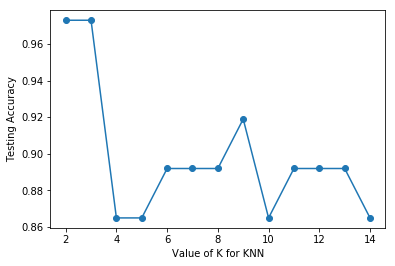

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
errors = []
scores=[]
for k in range(2,15):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_p = knn.predict(X_test)
    errors.append(100*(1 - knn.fit(X_train, y_train).score(X_test, y_test)))
    scores.append(metrics.accuracy_score(y_test, y_p))
#plt.plot(range(2,15), errors, 'o-')
plt.plot(range(2,15), scores, 'o-')
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.show()

### Classification & prediction
Il est extrêmement simple de former l''algorithme KNN et de faire des prédictions avec lui, en particulier lors de l''utilisation de Scikit-Learn.
La première étape consiste à importer la KNeighborsClassifierclasse depuis la `sklearn.neighbors` bibliothèque. Dans la deuxième ligne, cette classe est initialisée avec un paramètre, ie 'n_neigbours. Il s'agit essentiellement de la valeur de K. Il n'y a pas de valeur idéale pour K et elle est sélectionnée après test et évaluation, mais pour commencer, 5 semble être la valeur la plus couramment utilisée pour l'algorithme KNN.

In [68]:
#Classification
k=3
classifier = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
classifier.fit(X_train, y_train)

#prediction
y_pred = classifier.predict(X_test)

## Evaluation
Pour évaluer un algorithme, la matrice de confusion, la précision, le rappel et le score f1 sont les mesures les plus couramment utilisées. Les méthodes confusion_matrixet classification_reportde sklearn.metricspeuvent être utilisées pour calculer ces métriques. Jetez un œil au script suivant:

In [69]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Score: %f' % classifier.score(X_test,y_test))
print('Erreur: %f' % (1-classifier.score(X_test,y_test)))

[[19  1]
 [ 0 17]]
             precision    recall  f1-score   support

          0       1.00      0.95      0.97        20
          1       0.94      1.00      0.97        17

avg / total       0.97      0.97      0.97        37

Score: 0.972973
Erreur: 0.027027


### Plot
Nous allos afficher les éléments et leur comportement après prediction

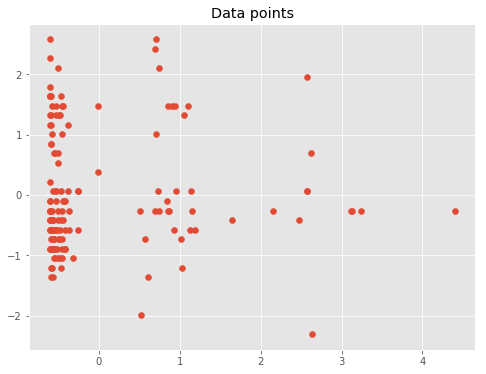

In [82]:
h = .02  # step size in the mesh

# Calculate min, max and limits
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Put the result into a color plot
plt.figure(figsize=(8, 6))
#ax = plt.fig.add_subplot(111)

plt.scatter(X_train[:, 0], X_train[:, 1])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Data points")

#plt.contourf(xx,yy,[[]],cmap=plt.cm.PRGn)
plt.axis('tight')
# Plot your testing points as wel
#for label in np.unique(y_test):
#    indices = np.where(y_test == label)
#    plt.scatter(X_test[indices, 0], X_test[indices, 1], c=colors[label], alpha=0.8, 
#                label='FP {}'.format(label))#


plt.legend(loc='lower right')

plt.show()